In [1]:
from lifelines import CoxPHFitter
import pandas as pd
import numpy as np
import plotnine as p9

The goal of Cox regression model is to asses the relationship of predictor variables to survival time of a certain event.

## Introduction

Let's start by creating a simple simulated dataset for survival models. We have 5 subjects labeled A to E. Each subject falls into one of the following categories:

- They underwent a preventive treatment (x = 1) or did not (x = 0) before the study.
- They either got a disease (event = 1) during the study or remained disease-free (event = 0).

If a subject contracted a disease, the "time" column indicates the specific timepoint when they acquired it. For subjects who did not develop any disease throughout the study, we list the last time point we checked on them (considered as timepoint 6) and label event = 0.

In simple terms, our only predictor variable is x, indicating whether the subject received preventive treatment. The event column is used to keep track of subjects who remained disease-free during the study ("censored"). Technically, if the study is long enough to capture all disease occurrences, the event column becomes redundant. However, most statistical packages for Cox regression require it regardless.

Our objective here is to assess whether the preventive treatment (x) increases the survival time - a duration before contracting a disease.

In [2]:
sample_df = pd.DataFrame({
    'subject': ['A', 'B', 'C', 'D', 'E'],
    'time': [1, 3, 5, 4, 6],
    'event': [1, 1, 1, 1, 0],
    'x': [0, 0, 0, 1, 1],
})

sample_df

,subject,time,event,x
0,A,1,1,0
1,B,3,1,0
2,C,5,1,0
3,D,4,1,1
4,E,6,0,1


In order to better visualize the events of getting a disease in this table, we can plot the data:

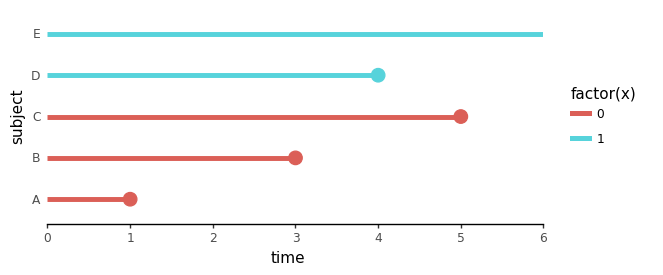

<ggplot: (8730598180084)>

In [3]:
def plot_eventtimes_per_subject(df, color_map='factor(x)'):
    return (
        p9.ggplot(
            df, p9.aes(x='time', y='subject', color=color_map)
        )
        + p9.geom_segment(
            p9.aes(x=0, xend='time', yend='subject'), size=2
        )
        + p9.geom_point(data=df[df['event'] == 1], shape='o', size=5, show_legend=False)
        + p9.scale_x_continuous(expand=[0, 0], breaks=range(7))
        + p9.coord_fixed(0.5)
        + p9.theme_classic()
        + p9.theme(
            axis_line_y=p9.element_blank(),
            axis_ticks_major_y=p9.element_blank()
        )
    )

plot_eventtimes_per_subject(sample_df)

On this plot, lines indicate the duration of time each subject experienced before getting a disease. The "getting a disease" event is marked with a filled circle. Subject E does not have a circle since it "survived" the entire study without getting a disease (experiencing an event). Teal colors are used for subjects D and E, who had gotten a preventive treatment (x = 1). Red colors are for subjects A, B and C who had not gotten a preventive treatment (x = 0).

Note: Throughout this post, we will focus on datasets where only one event occurs at each time. This simplification allows for a clearer understanding of the Cox model, as the mathematical equations become significantly more complex and can hinder intuitive comprehension when multiple events are tied.

## Hazards

Hazard represents the probability of an event occurring within a specific unit of time. It signifies the rate at which events take place and is measured in inverse time units. Unlike regular probability, which ranges between 0 and 1, hazard values can span from zero to infinity (e.g., 500 events per second). In a broader context, hazard can also vary over time. For instance, in the case of an event like "diagnosis with cancer," the hazard tends to increase with time.

In Cox regression, the hazard function, denoted as $h(t, x)$, is modeled in a manner akin to the odds in logistic regression. Logistic regression employs the odds ratio, represented as p/(1-p), to transform probabilities within the range of [0, 1] into odds, which have a skewed range of values: [0, ∞). Next, a logarithmic transformation is applied to the odds to produce values that reside within a symmetric interval of (-∞, ∞). This adjustment is made because the values derived from linear combinations of predictor variables also fall within the same interval.

Similarly, in Cox regression, the logarithm is utilized to transform the range of hazard values from [0, ∞) to (-∞, ∞). This transformation generates values within the (-∞, ∞) interval,  through linear combinations.

$$
\log h(t, x) = \beta x + \beta_0
$$

The main assumption of Cox regression is that any time dependence in log-hazard is _only_ part of the intercept term, $\beta_0(t)$:

$$
\log h(t, x) = \beta x + \beta_0(t)
$$

As we will see later, this assumption significantly simplifies the fitting process. Across the literature, the intercept term $\beta_0(t)$ is usually moved to the left side of the equation and instead expressed as a _baseline hazard_ $\log[h_0(t)]$:

$$
\log\left[\frac{h(t, x)}{h_0(t)}\right] = \beta x
$$

From this equation, we can expressed the hazard $h(t, x)$:

$$
h(t, x) = h_0(t) e^{\beta x}
$$

This equation does not seem particularly useful, unless we come up with a mathematical model for the baseline hazard $h_0(t)$?

## Fitting

It turns out, we can leave this pesky term $h_0(t)$ undefined, as it will completely cancel out when fitting a model, using a technique called Maximum Likelihood Estimation (short: MLE)! Likelihood is a probability of observing the data (here, survival times) given some model parameters (here, $\beta$).

How do we create an expression for likelihood in a Cox model?

##### 1. Sort events by their survival times.

_This is the only place where a survival time is used in a Cox model!_ In fact, as long as the ranking of survival times stays the same, their actual values _do not matter at all_. In our case:

In [19]:
sample_df.sort_values(by = 'time')

,subject,time,event,x
0,A,1,1,0
1,B,3,1,0
3,D,4,1,1
2,C,5,1,0
4,E,6,0,1


#### 2. Calculate likelihood for each time point

We start from subject A that underwent an event at time = 1. The likelihood of this event for subject A is the hazard of subject A at time 1, $h_A = h(t=1, x)$ as a proportion of the sum of all hazards at that time for all subjects that are still at risk for undergoing an event: $h_A + h_B + h_C + h_D + h_E$:

$$
L_A = L(t=1, \beta) = \frac{h_A}{h_A + h_B + h_D + h_C + h_E}
$$

$$
L_A = \frac{h_0(t) e^{\beta x_A}}{h_0(t) e^{\beta x_A} + h_0(t) e^{\beta x_B} + h_0(t) e^{\beta x_D} + h_0(t) e^{\beta x_C} + h_0(t) e^{\beta x_E}}
$$

$h_0(t)$ can be cancelled out from this expression, and after plugging in various values for $x$ we get:

$$
L_A = \frac{1}{1 + 1 +  e^{\beta} + 1 + e^{\beta}} = \frac{1}{3 + 2e^{\beta}}
$$

Next, we move on to the second time point (t = 3) when subject B undergoes an event and we repeat this process. Keep in mind that subject A is now excluded, since it already experienced an event before:

$$
L_B = \frac{h_B}{h_B + h_D + h_C + h_E} = \frac{1}{1 + e^{\beta} + 1 + e^{\beta}} = \frac{1}{2 + 2e^{\beta}}
$$

We keep going until we write down likelihoods for all subjects that experienced an event (E is just left out):

$$
L_D = \frac{h_D}{h_D + h_C + h_E} = \frac{e^{\beta}}{1 + 2e^{\beta}}
$$

$$
L_C = \frac{h_C}{h_C + h_E} = \frac{1}{1 + e^{\beta}}
$$

#### 3. Find $\beta$ for which sum of log-likelihoods is maximal

If each event occurs independently of each other, the total probability (likelihood) is simply the product of individual likelihoods $L = L_A L_B L_D L_C$. However, products of many expressions that contain exponential functions can produce very large numbers that can lead to large numerical errors, so typically this likelihood is log-transformed. Logarithm of a product then becomes a sum of logarithms across all subjects and we call this expression "log-likelihood":

$$
\log L = \log L_A + \log L_B + \log L_D + \log L_C
$$

### Implementation

We can implement this algorithm in Python:

In [81]:
def log_likelihood(df, subject, beta):
    subject_with_event_df = df.query(f"subject == '{subject}' & event == 1")
    time, x = subject_with_event_df.iloc[0][['time', 'x']]
    x_subjects_at_risk = df.query(f"time >= {time}")['x']
    at_risk_hazards = np.exp(beta*x_subjects_at_risk)
    return beta*x - np.log(np.sum(at_risk_hazards))

In [102]:
def neg_log_likelihood_all_subjects(df, beta):
    subjects = df.query("event == 1")['subject'].tolist()
    neg_log_likelihoods = [-log_likelihood(df, subject, beta) for subject in subjects]
    return (
        pd.DataFrame({
            'subject': subjects,
            'neg_log_likelihood': neg_log_likelihoods
        })
    )

In [103]:
neg_log_likelihood_all_subjects(sample_df, 2)

,subject,neg_log_likelihood
0,A,2.877968
1,B,2.820075
2,C,2.126928
3,D,0.758624


In [104]:
def neg_log_likelihood_all_subjects_betas(df, betas=np.arange(-5, 5, 0.5)):
    loglikelihoods_per_beta = []
    for beta in betas:
        beta_df = neg_log_likelihood_all_subjects(df, beta)
        beta_df.insert(0, 'beta', beta)
        loglikelihoods_per_beta.append(beta_df)
    return pd.concat(loglikelihoods_per_beta)

In [105]:
negloglik_beta_df = neg_log_likelihood_all_subjects_betas(sample_df)
negloglik_beta_df.head(10)

,beta,subject,neg_log_likelihood
0,-5.0,A,1.103094
1,-5.0,B,0.699863
2,-5.0,C,0.006715
3,-5.0,D,5.013386
0,-4.5,A,1.105991
1,-4.5,B,0.704195
2,-4.5,C,0.011048
3,-4.5,D,4.521975
0,-4.0,A,1.110749
1,-4.0,B,0.711297


In [106]:
def plot_cost_vs_beta(df, betas=np.arange(-5, 5.5, 0.1)):
    negloglik_beta_df = neg_log_likelihood_all_subjects_betas(df, betas)
    return (
        p9.ggplot(negloglik_beta_df, p9.aes('beta', 'neg_log_likelihood', fill='subject'))
        + p9.geom_col(width=betas[1]-betas[0])
        + p9.scale_x_continuous(expand=[0, 0])
        + p9.scale_y_continuous(name='negative log-likelihoods ("cost")', expand=[0, 0])
        + p9.theme_classic()
    )

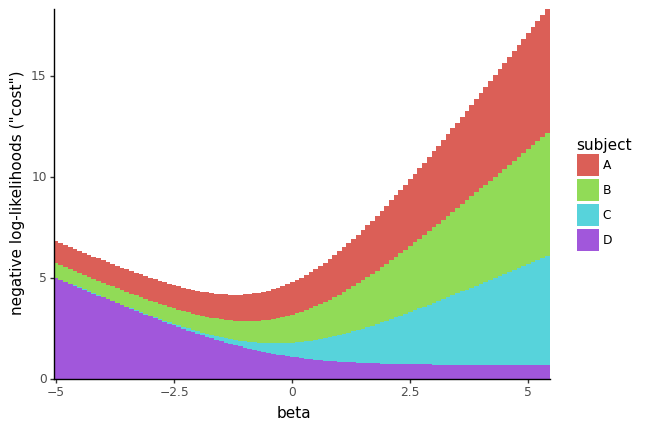

<ggplot: (8730591533129)>

In [107]:
plot_cost_vs_beta(sample_df)

Large bars = small likelihoods

If $\beta$ is negative, then the hazards of subjects with x = 1 (A, B, C) get suppressed

In [10]:
def total_log_likelihood(df, beta):
    subjects = df['subject'].unique()
    sum_log_likelihood = 0
    for subject in subjects:
        sum_log_likelihood += log_likelihood(df, subject, beta)
    return(sum_log_likelihood)

In [11]:
def total_loglik_vs_beta(df, betas=np.arange(-5, 5, 0.1)):
    total_log_likelihoods = [total_log_likelihood(df, beta) for beta in betas]
    return(
        pd.DataFrame({
            'beta': betas,
            'total_log_lik': total_log_likelihoods
        })
    )

In [12]:
fit_df = total_loglik_vs_beta(sample_df)
fit_df

,beta,total_log_lik
0,-5.0,-6.823058
1,-4.9,-6.726333
2,-4.8,-6.629949
3,-4.7,-6.533940
4,-4.6,-6.438346
...,...,...
95,4.5,-15.623602
96,4.6,-15.919423
97,4.7,-16.215638
98,4.8,-16.512209


In [13]:
cph = CoxPHFitter()
cph.fit(sample_df, duration_col='time', event_col='event', formula='x')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 5 total observations, 1 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 5
number of events observed = 4
   partial log-likelihood = -4.17
         time fit was run = 2023-06-01 02:54:04 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
x          -1.21       0.30       1.17            -3.51             1.09                 0.03                 2.98

            cmp to     z    p   -log2(p)
covariate                               
x             0.00 -1.03 0.30       1.72
---
Concordance = 0.70
Partial AIC = 10.35
log-likelihood ratio test = 1.23 on 1 df
-log2(p) of ll-ratio test = 1.90

## Continuous example

In [14]:
sample_cont_df = pd.DataFrame({
    'subject': ['A', 'B', 'C', 'D', 'E'],
    'time': [1, 3, 4, 5, 6],
    'event': [1, 1, 1, 1, 0],
    'x': [0.1, 0.2, 0.3, 0.9, 1.2],
})

sample_cont_df

,subject,time,event,x
0,A,1,1,0.1
1,B,3,1,0.2
2,C,4,1,0.3
3,D,5,1,0.9
4,E,6,0,1.2


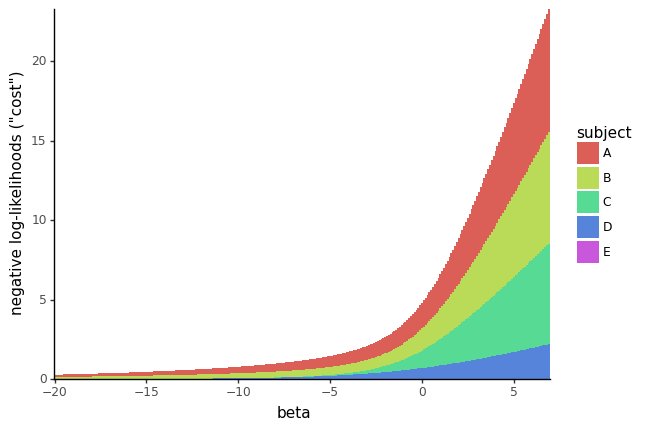

<ggplot: (8730593646210)>

In [15]:
plot_cost_vs_beta(sample_cont_df, betas=np.arange(-20, 7, 0.1))

In [16]:
sample_cont_cox = CoxPHFitter()
sample_cont_cox.fit(sample_cont_df, )

KeyError: None